In [1]:
import pandas as pd
from verstack import LGBMTuner
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, log_loss
import shap
import numpy as np
from lightgbm import LGBMRegressor

2024-05-20 20:45:28.573358: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-20 20:45:28.573406: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-20 20:45:28.574366: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-20 20:45:28.671706: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-20 20:45:30.158698: W tensorflow/compiler/

In [5]:
train_path = "Data files/AppML_InitialProject_train.h5"
test_path = "Data files/AppML_InitialProject_test_regression.h5"
train_df = pd.read_hdf(train_path)
train_df = train_df[train_df["p_Truth_Energy"] > 0]
test_df = pd.read_hdf(test_path)
data_train = train_df.iloc[:, :-2]
data_regr_target = train_df.iloc[:, -1]

In [6]:
X_train_init, X_test_init, y_train_init, y_test_init = train_test_split(
    data_train, data_regr_target, test_size=0.1, random_state=42
)
tuner = LGBMTuner(metric = 'mae', trials=20)


 * Initiating LGBMTuner.fit
     . Settings:
     .. Trying 20 trials
     .. Evaluation metric: mae 
     .. Study direction: minimize mean_absolute_error

     . Trial number: 0 finished
     .. Optimization score (lower-better): mean_absolute_error: 5428.101802234682
     .. Evaluation score (lower-better): mae: 5428.101802234682
 ...........................................................................
     . Trial number: 1 finished
     .. Optimization score (lower-better): mean_absolute_error: 5422.8178424390035
     .. Evaluation score (lower-better): mae: 5422.8178424390035
 ...........................................................................
     . Trial number: 2 finished
     .. Optimization score (lower-better): mean_absolute_error: 5665.714521947701
     .. Evaluation score (lower-better): mae: 5665.714521947701
 ...........................................................................
     . Trial number: 3 finished
     .. Optimization score (lower-better): 

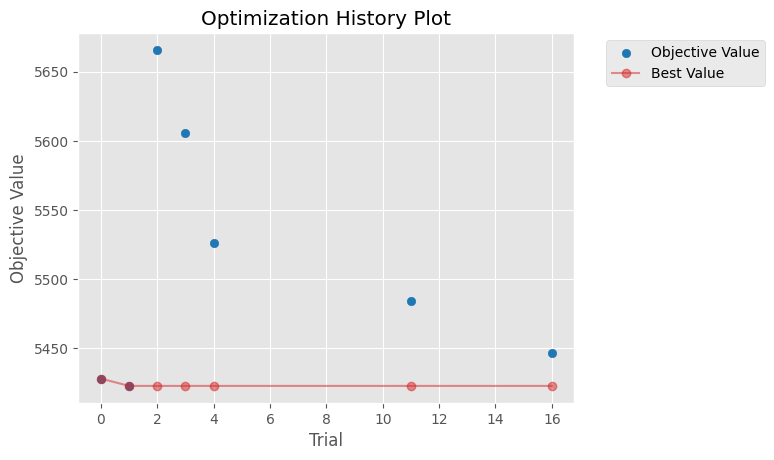

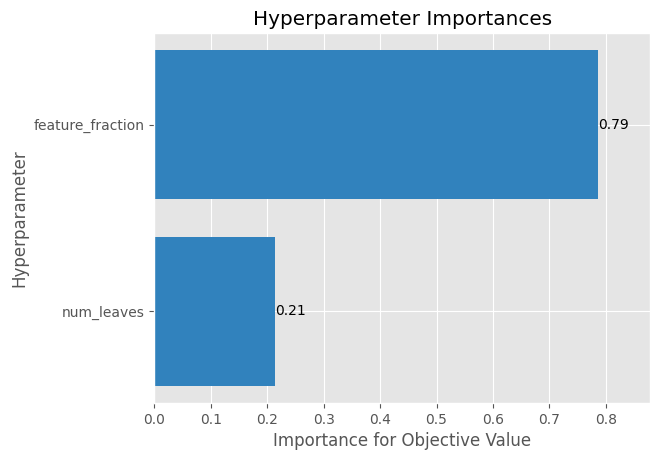

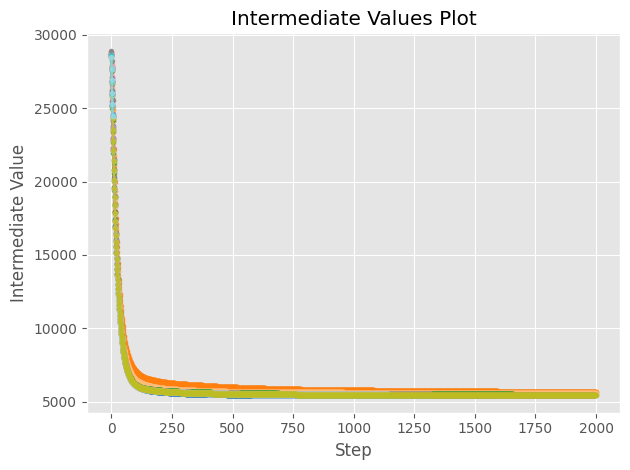

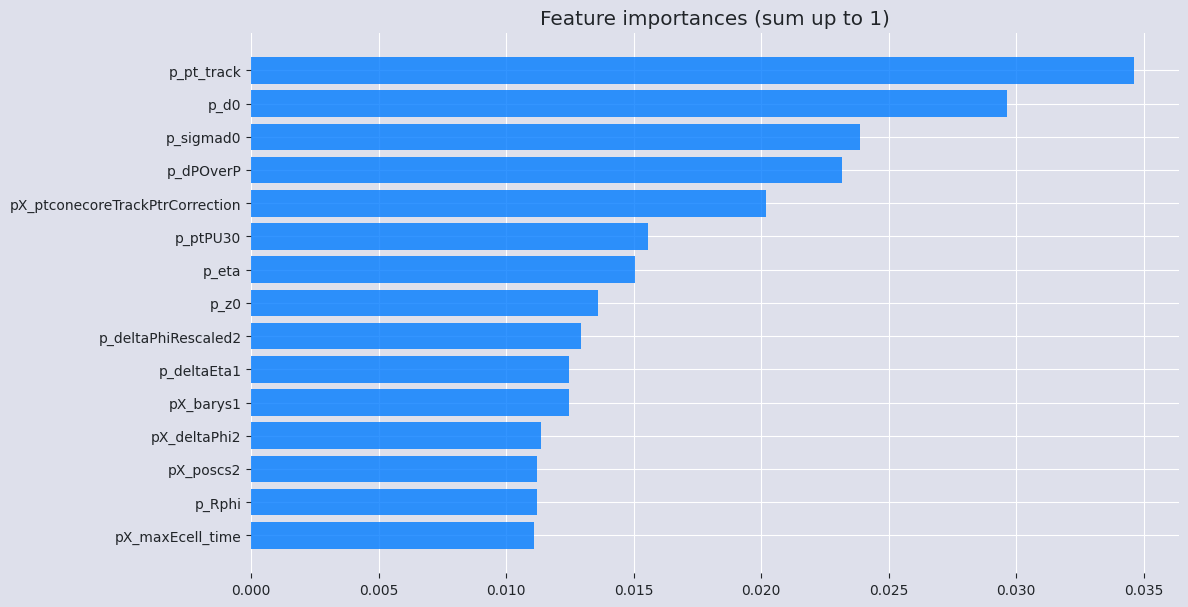


     . Optuna hyperparameters optimization finished
     .. Best trial number: 1    |     mean_absolute_error:           5422.8178424390035
 ---------------------------------------------------------------------------

Time elapsed for fit execution: 11 min 1.66 sec


In [6]:
tuner.fit(X_train_init, y_train_init)

In [5]:
# MAPE: 1.1850125643598997
best_params = dict(bagging_fraction=0.9, device_type='cpu',
              feature_fraction=0.8659969709057025, learning_rate=0.04,
              metric='l1', num_iterations=1999, num_leaves=159, num_threads=10,
              objective='regression', random_state=42, verbosity=-1)
bst = LGBMRegressor(**best_params)
bst.fit(X_train_init, y_train_init)

LGBMRegressor(bagging_fraction=0.9, device_type='cpu',
              feature_fraction=0.8659969709057025, learning_rate=0.04,
              metric='l1', num_iterations=1999, num_leaves=159, num_threads=10,
              objective='regression', random_state=42, verbosity=-1)

In [6]:
explainer = shap.TreeExplainer(bst)

In [13]:
shap_values = explainer.shap_values(X_test_init)

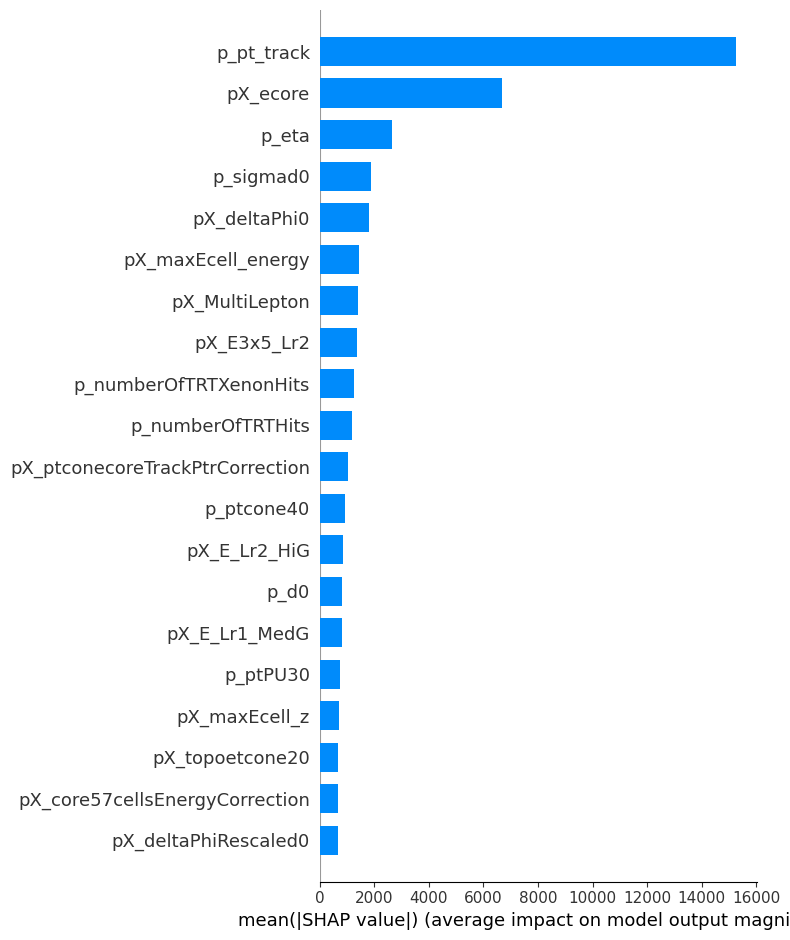

In [14]:
# feature_importances_all = tuner.feature_importances.sort_values(ascending=False)
# selected_features = feature_importances_all.iloc[0:25].index.values
shap.summary_plot(shap_values, pd.DataFrame(X_test_init, columns=data_train.columns), plot_type="bar")

In [25]:
selected_features = data_train.columns[np.argsort(np.mean(np.abs(shap_values), axis=0))[::-1]][0:25].values.tolist()
print(selected_features)

['p_pt_track', 'pX_ecore', 'p_eta', 'p_sigmad0', 'pX_deltaPhi0', 'pX_maxEcell_energy', 'pX_MultiLepton', 'pX_E3x5_Lr2', 'p_numberOfTRTXenonHits', 'p_numberOfTRTHits', 'pX_ptconecoreTrackPtrCorrection', 'p_ptcone40', 'pX_E_Lr2_HiG', 'p_d0', 'pX_E_Lr1_MedG', 'p_ptPU30', 'pX_maxEcell_z', 'pX_topoetcone20', 'pX_core57cellsEnergyCorrection', 'pX_deltaPhiRescaled0', 'pX_topoetcone40ptCorrection', 'pX_deltaPhi2', 'p_deltaPhiRescaled2', 'p_dPOverP', 'pX_nCells_Lr0_HiG']


In [7]:
# selected_features = ['p_pt_track', 'p_d0', 'p_sigmad0', 'p_dPOverP',
#        'pX_ptconecoreTrackPtrCorrection', 'p_eta', 'p_ptPU30',
#        'p_deltaPhiRescaled2', 'p_z0', 'p_deltaEta1', 'pX_barys1',
#        'pX_deltaPhi2', 'p_Rphi', 'pX_core57cellsEnergyCorrection',
#        'pX_deltaPhiFromLastMeasurement', 'pX_maxEcell_time',
#        'p_numberOfSCTHits', 'pX_E_Lr1_HiG', 'pX_deltaEta2',
#        'pX_E_Lr2_HiG', 'pX_poscs2', 'pX_ehad1', 'pX_maxEcell_energy',
#        'pX_nCells_Lr1_HiG', 'pX_deltaEta3']
selected_features = [
    "p_pt_track",
    "pX_ecore",
    "p_eta",
    "p_sigmad0",
    "pX_deltaPhi0",
    "pX_maxEcell_energy",
    "pX_MultiLepton",
    "pX_E3x5_Lr2",
    "p_numberOfTRTXenonHits",
    "p_numberOfTRTHits",
    "pX_ptconecoreTrackPtrCorrection",
    "p_ptcone40",
    "pX_E_Lr2_HiG",
    "p_d0",
    "pX_E_Lr1_MedG",
    "p_ptPU30",
    "pX_maxEcell_z",
    "pX_topoetcone20",
    "pX_core57cellsEnergyCorrection",
    "pX_deltaPhiRescaled0",
    "pX_topoetcone40ptCorrection",
    "pX_deltaPhi2",
    "p_deltaPhiRescaled2",
    "p_dPOverP",
    "pX_nCells_Lr0_HiG",
]
X_train, X_test, y_train, y_test = train_test_split(
    data_train[selected_features], data_regr_target, test_size=0.1, random_state=42
)

In [8]:
tuner_final = LGBMTuner(metric="mae", trials=100)


 * Initiating LGBMTuner.fit
     . Settings:
     .. Trying 100 trials
     .. Evaluation metric: mae 
     .. Study direction: minimize mean_absolute_error

     . Trial number: 0 finished
     .. Optimization score (lower-better): mean_absolute_error: 4725.3590751349575
     .. Evaluation score (lower-better): mae: 4725.3590751349575
 ...........................................................................
     . Trial number: 1 finished
     .. Optimization score (lower-better): mean_absolute_error: 4788.892875821065
     .. Evaluation score (lower-better): mae: 4788.892875821065
 ...........................................................................
     . Trial number: 2 finished
     .. Optimization score (lower-better): mean_absolute_error: 4708.767243917945
     .. Evaluation score (lower-better): mae: 4708.767243917945
 ...........................................................................
     . Trial number: 3 finished
     .. Optimization score (lower-better):

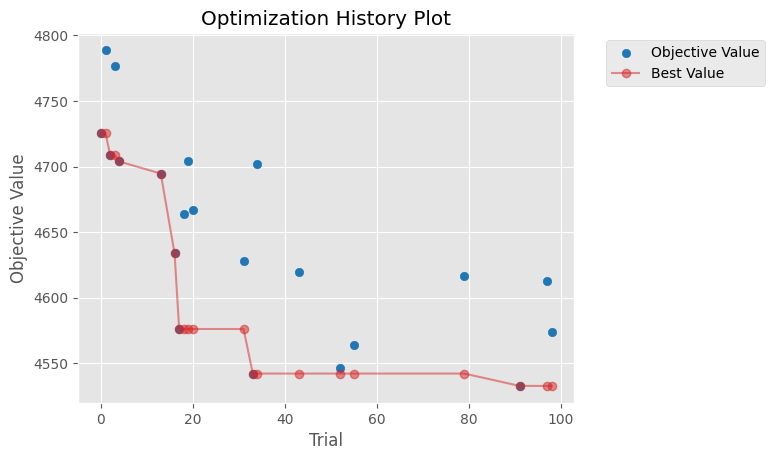

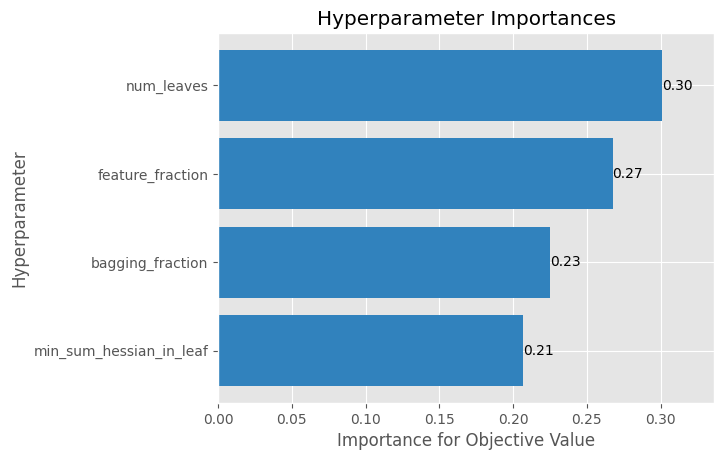

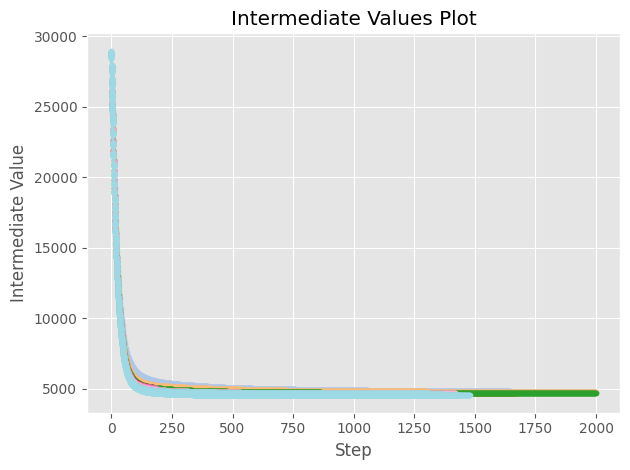

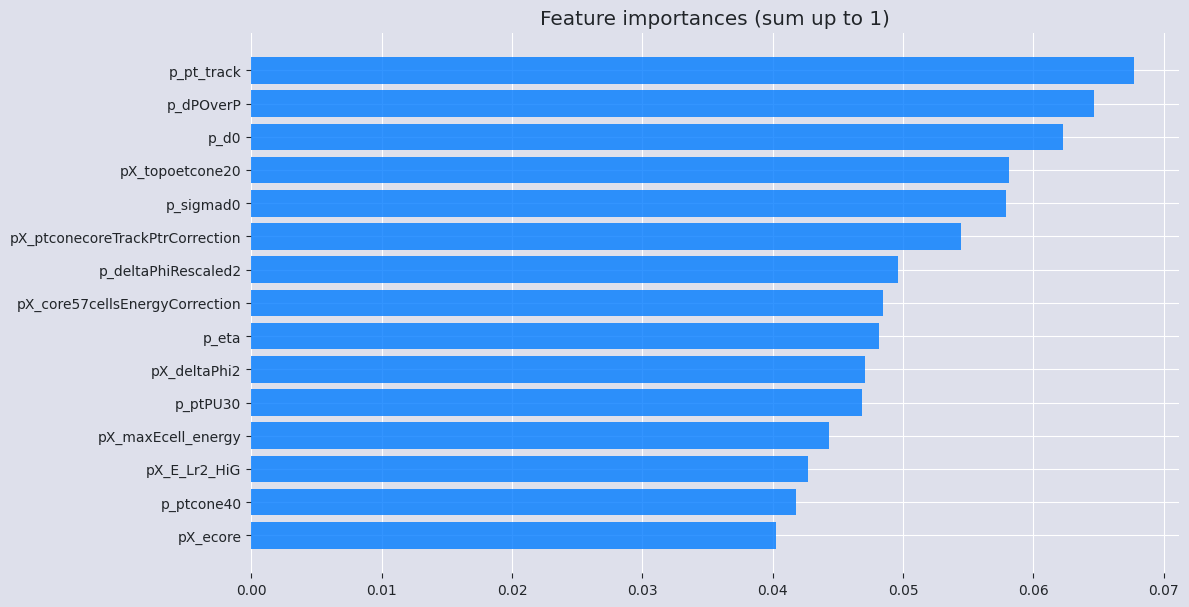


     . Optuna hyperparameters optimization finished
     .. Best trial number:91    |     mean_absolute_error:            4532.795466095558
 ---------------------------------------------------------------------------

Time elapsed for fit execution: 6 min 24.096 sec


In [9]:
tuner_final.fit(X_train, y_train)

In [10]:
validation_pred = tuner_final.predict(X_test)

In [11]:
from sklearn.metrics import mean_absolute_percentage_error

In [12]:
# 0.609465676098521
print(mean_absolute_percentage_error(y_test, validation_pred))

0.609465676098521


In [13]:
pred_final = tuner_final.predict(test_df[selected_features])
csv_out_path = "Solution_files/Regression_AliAhmad_LightGBM.csv"
pd.Series(pred_final).to_csv(csv_out_path, sep=",", header=None)

In [39]:
features_out_path = "Solution_files/Regression_AliAhmad_LightGBM_VariableList.csv"

with open(features_out_path, "w") as f:
    for feature in selected_features:
        f.write(f"{feature},\n")

In [14]:
tuner_final.best_params

{'learning_rate': 0.04,
 'num_leaves': 234,
 'feature_fraction': 0.759668935721035,
 'bagging_fraction': 0.6633729386653552,
 'verbosity': -1,
 'random_state': 42,
 'device_type': 'cpu',
 'objective': 'regression',
 'metric': 'l1',
 'num_threads': 10,
 'min_sum_hessian_in_leaf': 6.704493315098196,
 'num_iterations': 1160}